In [1]:
!rm -rf test && mkdir -p test && cd test && git clone https://github.com/thu-coai/cotk.git && pip3 install ./cotk
!pip install livelossplot

Cloning into 'cotk'...
Processing ./cotk


In [2]:
  from cotk.dataloader import MSCOCO
  from pprint import pprint
  dataloader = MSCOCO("resources://MSCOCO_small") # "resources://MSCOCO_small" is a predefined resources name
  print("Vocab Size:", dataloader.vocab_size)
  print("First 10 tokens:",  dataloader.vocab_list[:10])
  print("Dataset is split into:", dataloader.key_name)
  data = dataloader.get_batch("train", [0]) # get the sample of id 0
  pprint(data, width=200)
  print(dataloader.convert_ids_to_tokens(data['sent'][0]))

INFO: name: MSCOCO_small
INFO: source: default
INFO: processor type: MSCOCO
INFO: MSCOCO_small exists in cache
INFO: resource cached at /root/.cotk_cache/9e4c0afe33d98fa249e472206a39e5553d739234d0a27e055044ae8880e314b1_unzip/mscoco
valid vocab list length = 2588
vocab list length = 12411
train set. invalid rate: 0.031716, unknown rate: 0.000000, max length before cut: 55, cut word rate: 0.000022
dev set. invalid rate: 0.034089, unknown rate: 0.000000, max length before cut: 46, cut word rate: 0.000000
test set. invalid rate: 0.031213, unknown rate: 0.000000, max length before cut: 27, cut word rate: 0.000000
Vocab Size: 2588
First 10 tokens: ['<pad>', '<unk>', '<go>', '<eos>', '.', 'a', 'A', 'on', 'of', 'in']
Dataset is split into: ['train', 'dev', 'test']
{'sent': array([[  2,   6,  67, 651, 549,  11,   5,  65,  89,  10, 115, 349,  83,
          4,   3]]),
 'sent_allvocabs': array([[  2,   6,  67, 651, 549,  11,   5,  65,  89,  10, 115, 349,  83,
          4,   3]]),
 'sent_length': a

In [0]:
  import torch
  from torch import nn

  embedding_size = 20
  hidden_size = 20

  class LanguageModel(nn.Module):
      def __init__(self):
          super().__init__()
          self.embedding_layer = nn.Embedding(dataloader.vocab_size, embedding_size)
          self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True)
          self.output_layer = nn.Linear(hidden_size, dataloader.vocab_size)
          self.crossentropy = nn.CrossEntropyLoss()
          
          from cotk.wordvector import Glove
          wordvec = Glove("resources://Glove50d_small")
          self.embedding_layer.weight = nn.Parameter(torch.Tensor(wordvec.load(embedding_size, dataloader.vocab_list)))

      def forward(self, data):
          # data is the dict returned by ``dataloader.get_batch``
          sent = data['sent']
          sent_length = data['sent_length']
          # sent is a LongTensor whose shape is (batch_size, sent_length)
          # sent_length is a list whose size is (batch_size)

          incoming = self.embedding_layer(sent)
          # incoming: (batch_size, sent_length, embedding_size)
          incoming, _ = self.rnn(incoming)
          # incoming: (batch_size, sent_length, hidden_size)
          incoming = self.output_layer(incoming)
          # incoming: (batch_size, sent_length, dataloader.vocab_size)

          loss = []
          for i, length in enumerate(sent_length):
              if length > 1:
                  loss.append(self.crossentropy(incoming[i, :length-1], sent[i, 1:length]))
                  # every time step predict next token

          data["gen_log_prob"] = nn.LogSoftmax(dim=-1)(incoming)

          if len(loss) > 0:
             return torch.stack(loss).mean()
          else:
              return 0


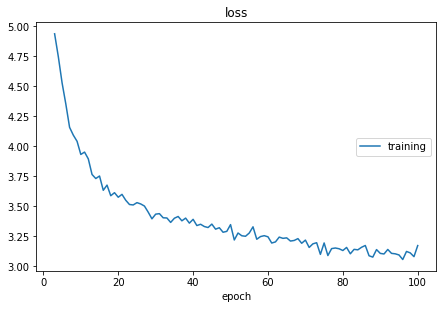

loss:
training   (min:    3.056, max:    6.445, cur:    3.172)
epoch 100/100


In [4]:
    from livelossplot import PlotLosses
    import numpy as np

    net = LanguageModel()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
    epoch_num = 100
    batch_size = 16
    plot = PlotLosses()

    for j in range(epoch_num):
        loss_arr = []
        for i, data in enumerate(dataloader.get_batches("train", batch_size)):
            # convert numpy to torch.LongTensor
            data['sent'] = torch.LongTensor(data['sent'])
            net.zero_grad()
            loss = net(data)
            loss_arr.append(loss.tolist())
            loss.backward()
            optimizer.step()
            if i >= 40:
                break # break for shorten time of an epoch
        plot.update({"loss": np.mean(loss_arr)})
        plot.draw()
        print("epoch %d/%d" % (j+1, epoch_num))

In [5]:
metric = dataloader.get_teacher_forcing_metric(gen_log_prob_key="gen_log_prob")
for i, data in enumerate(dataloader.get_batches("test", batch_size)):
    # convert numpy to torch.LongTensor
    data['sent'] = torch.LongTensor(data['sent'])
    with torch.no_grad():
        net(data)
    assert "gen_log_prob" in data
    metric.forward(data)
pprint(metric.close(), width=150)

test set restart, 78 batches and 2 left
{'perplexity': 30.487945232812304, 'perplexity hashvalue': '4f101c2986f1fe10ce1d2197c3086d3659aec3e6495f381d67f00b4dbb40a538'}


In [6]:
metric = dataloader.get_inference_metric(gen_key="gen")
generate_sample_num = 1
max_sent_length = 20

for i in range(generate_sample_num):
    # convert numpy to torch.LongTensor
    data['sent'] = torch.LongTensor([[dataloader.go_id] for _ in range(batch_size)])
    data['sent_length'] = np.array([1 for _ in range(batch_size)])
    for j in range(max_sent_length):
        with torch.no_grad():
            net(data)
            generated_token = torch.multinomial(data['gen_log_prob'].exp()[:, -1], 1)
        data['sent'] = torch.cat([data['sent'], generated_token], dim=-1)

    metric.forward({"gen": data['sent'][:, 1:].tolist()})
pprint(metric.close(), width=250)

100%|██████████| 1000/1000 [00:00<00:00, 1028.00it/s]

{'bw-bleu': 0.04672408449806719,
 'fw-bleu': 0.21161289087175142,
 'fw-bw-bleu': 0.07654667768574586,
 'fw-bw-bleu hashvalue': '3018dc317f82b6013f011c1f8ccd90c5affed710b7d7d06a7235cf455c233542',
 'gen': [['A', 'man', '<unk>', 'horses', 'are', 'practicing', 'at', 'the', 'wild', '.'],
         ['Two', 'guys', 'on', 'skis', 'gets', 'its', 'war', 'through', 'a', 'hill', '.'],
         ['A', 'baseball', 'player', 'with', 'a', 'bat', 'over', 'an', 'airplane', '.'],
         ['A', 'female', 'bird', 'is', 'eating', 'a', 'museum', 'low', 'on', 'it', '.'],
         ['A', 'woman', 'are', 'running', 'with', '<unk>', 'tables', 'are', 'wearing', 'a', 'meal', '.'],
         ['A', 'woman', 'holding', 'a', 'half', 'eaten', 'with', 'boxes', 'in', 'the', 'container', '.'],
         ['Three', 'photos', 'in', 'a', 'black', 'some', 'vase', '.'],
         ['A', 'cute', 'small', 'furry', 'giraffe', 'is', 'drives', 'through', 'a', 'ramp', '.'],
         ['A', 'street', 'kitchen', 'with', 'lots', 'of', 'teddy',

In [7]:
metric = dataloader.get_teacher_forcing_metric(gen_log_prob_key="gen_log_prob")
for i, data in enumerate(dataloader.get_batches("test", batch_size)):
    # convert numpy to torch.LongTensor
    data['sent'] = torch.LongTensor(data['sent'])
    with torch.no_grad():
        net(data)
    assert "gen_log_prob" in data
    metric.forward(data)
    if i >= 15: #ignore the following batches
        break
pprint(metric.close(), width=150)

test set restart, 78 batches and 2 left
{'perplexity': 33.6496264311846, 'perplexity hashvalue': '3f9641fb8888a8cd85828992443353cacf28a24fe9ec710c384a90b14e2dd01c'}
